In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.applications as app
import keras.layers as kl
import seaborn as sns
import matplotlib.patheffects as PathEffects
import cv2
import os
import mlflow
import mlflow.keras

from tqdm import tqdm as tqdm
from keras.models import Model, Sequential
from keras.optimizers import Adagrad
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from time import time
from sklearn.manifold import TSNE
from mpl_toolkits import mplot3d
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
m = 1.09
activation = None
reg = False
epoch = 2

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train_),(x_test, y_test_) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = np.reshape(x_train, (60000, 28, 28, 1))
x_test  = np.reshape(x_test, (10000, 28, 28, 1))

x_movie = x_train[:500]
y_movie = y_train_[:500]

y_train2 = np.zeros((60000, 10))
for j, i in enumerate(y_train_):
    y_train2[j, i] = 1
    
y_test2 = np.zeros((10000, 10))
for j, i in enumerate(y_test_):
    y_test2[j, i] = 1

In [5]:
def triplet_generation(x, y, sample = 500):
    data = [[] for _ in range(10)]
    triplets = []
    for pair in zip(x, y):
        data[pair[1]].append(pair[0])
    for number in range(10):
        for _ in range(sample):
            negative = list(range(10))
            negative.pop(number)
            negative = random.choice(negative)
            triplet = ([random.choice(data[number]), 
                       random.choice(data[number]), 
                       random.choice(data[negative])], 
                       number)
            triplets.append(triplet)
    return np.array(triplets)

In [6]:
def get_mask(classes):
    dot_product_positive = np.dot(classes, np.transpose(classes))
    classes_neg = np.ones(classes.shape) - classes
    dot_product_negative = np.dot(classes, np.transpose(classes_neg))

    dot_product_positive = dot_product_positive[..., np.newaxis]
    dot_product_negative = dot_product_negative[:, np.newaxis, :]
    
    mask = np.matmul(dot_product_positive, np.transpose(dot_product_negative))
    return mask

In [7]:
def one_hot(y):
    encodded = np.zeros((len(y), 10))
    for i in range(len(encodded)):
        encodded[i, y[i]] = 1
    return encodded

In [8]:
def get_triplets(model, x_train, y_train):
    embeddings = model.predict(x_train)
    classes = np.argmax(y_train, axis = 1)
    triplet = []
    distances = distance_matrix(embeddings)
    classes_neg = np.ones(y_train.shape) - y_train
    mask_neg = np.dot(y_train, np.transpose(classes_neg))
    distances = distances * mask_neg
    distances[distances == 0] = np.max(distances) + 1
    for i, anchor in enumerate(x_train):
        validate = np.where(classes == classes[i])[0]
        for j in validate:
            k = np.random.choice((-distances[i]).argsort()[-1:][::-1])
            triplet.append((i, j, k))
    return triplet

In [9]:
def distance_matrix(embeddings, squared=False):
    dot_product = np.dot(embeddings, np.transpose(embeddings))
    square_norm = np.diagonal(dot_product)
    distances = np.tile(square_norm, (square_norm.shape[0], 1)) - 2.0 * dot_product + np.transpose(np.tile(square_norm, (square_norm.shape[0], 1)))
    distances[distances < 0.0] = 0.0
    
    if not squared:
        mask = distances == 0.0
        distances = distances + mask * 1e-16
        distances = np.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances

In [10]:
boucles = [0, 2, 6, 9, 8]
def triplet_loss(y_true, y_pred, m = m):
    length = int((y_pred[0].shape[-1]))
    
    y_anchor    = np.array(y_true[:, 0])
    y_negative  = np.array(y_true[:, 1])
    opposite_class  = np.bitwise_xor(np.isin(y_anchor, boucles), np.isin(y_negative, boucles))
    
    anchor_vec   = y_pred[:, :int(length/3)]
    positive_vec = y_pred[:, int(length/3):int(length/1.5)]
    negative_vec = y_pred[:, int(length/1.5):length]
    
    bad  = K.sum(K.square(anchor_vec - positive_vec), axis = 1)
    good = K.sum(K.square(anchor_vec - negative_vec * (1 - 0.5*opposite_class)), axis = 1)

    loss = bad - good + m
    return K.maximum(loss, 0.)

In [11]:
anchor_input   = kl.Input((28, 28, 1), name = 'anchor_input')
positive_input = kl.Input((28, 28, 1), name = 'positive_input')
negative_input = kl.Input((28, 28, 1), name = 'negative_input')

In [12]:
def base_model():
    model = Sequential()
    model.add(kl.Conv2D(32, 2, input_shape=(28, 28,1), activation='relu', padding='valid'))
    model.add(kl.MaxPooling2D())
    model.add(kl.Conv2D(64, 2, activation='relu', padding='valid'))
    model.add(kl.MaxPooling2D())
    model.add(kl.Flatten())
    model.add(kl.Dense(256, activation = 'relu'))
    model.add(kl.Dropout(0.5))
    model.add(kl.Dense(10, activation = activation))
    model.add(kl.Lambda(lambda t: K.l2_normalize(1000*t, axis=1)))
    
    return model

In [13]:
shared_network = base_model()

C:\Users\Utilisateur\.conda\envs\keelab\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
anchor   = shared_network(anchor_input)
positive = shared_network(positive_input)
negative = shared_network(negative_input)

merged = kl.concatenate([anchor, positive, negative], axis = 1)

model  = Model(inputs = [anchor_input, positive_input, negative_input], outputs = merged)
loaded_model = Model(inputs = anchor_input, outputs = anchor)

In [15]:
opt = Adagrad()

In [16]:
model.compile(optimizer = opt, loss = triplet_loss)

In [18]:
for _ in tqdm(range(epoch)):
    c = list(zip(x_train, y_train_))
    random.shuffle(c)
    x_train, y_train_ = zip(*c)
    x_train   = np.array(x_train)
    y_train_  = np.array(y_train_)
    for batch in range(0, len(x_train), 32):
        loaded_model.set_weights(model.get_weights())
        anchor    = []
        positive  = []
        negative  = []
        y         = []
        data_x    = x_train[batch: batch+32]
        data_y    = y_train_[batch: batch+32]
        one_hot_y = one_hot(data_y)
        triplets  = get_triplets(loaded_model, data_x, one_hot_y)
        for (i, j, k) in triplets:
            anchor.append(data_x[i])
            positive.append(data_x[j])
            negative.append(data_x[k])
            y.append([data_y[i], data_y[k]])
        y = np.array(y)
        model.fit([anchor, positive, negative], y, batch_size = 32, verbose = 0)
        if not batch % (32*70):
            x = model.predict(3*[x_movie[:500].reshape(-1,28,28,1)])[:, :3]
            palette = np.array(sns.color_palette("hls", 10))
            fig = plt.figure(figsize = (10,10))
            ax  = plt.axes(projection="3d")
            ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                                c=palette[np.array(y_movie[:500]).astype(np.int)]);
            ax.set_xlim(-2, 2)
            ax.set_ylim(-2, 2)
            ax.set_zlim(-2, 2)
            fig.savefig('./movie/{}{}.png'.format((_ * batch) // 70))
            plt.close(fig)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [47:28<00:00, 1450.58s/it]


(-1.5, 1.5)

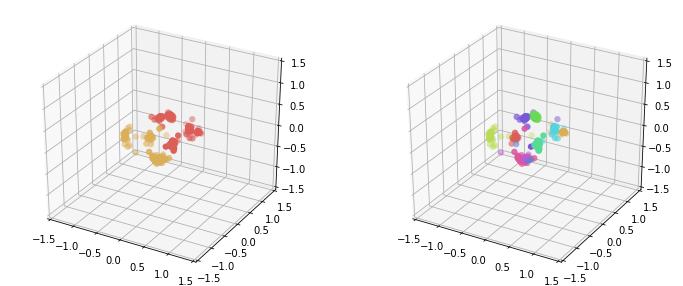

In [45]:
x = model.predict(3*[x_movie[:500].reshape(-1,28,28,1)])[:, :3]
palette = np.array(sns.color_palette("hls", 10))
fig = plt.figure(figsize=(12, 11))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                    c=palette[np.array(np.isin(y_movie[:500], boucles)).astype(np.int)]);
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
axi = fig.add_subplot(2, 2, 2, projection='3d')
axi.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                    c=palette[np.array(y_movie[:500]).astype(np.int)]);
axi.set_xlim(-1.5, 1.5)
axi.set_ylim(-1.5, 1.5)
axi.set_zlim(-1.5, 1.5)

In [46]:
model.save_weights('./poid_last.h5')

In [117]:
data_train = triplet_generation(x_train, y_train_, 3500)

In [118]:
data_test  = triplet_generation(x_test, y_test_, 200)

In [119]:
anchor_train   = []
positive_train = []
negative_train = []
y_train        = []
np.random.shuffle(data_train)
for data in data_train:
    anchor_train.append(data[0][0])
    positive_train.append(data[0][1])
    negative_train.append(data[0][2])
    y_train.append(data[1])

In [120]:
anchor_test   = []
positive_test = []
negative_test = []
y_test        = []
np.random.shuffle(data_test)
for data in data_test:
    anchor_test.append(data[0][0])
    positive_test.append(data[0][1])
    negative_test.append(data[0][2])
    y_test.append(data[1])

In [ ]:
def dist_matrix(embeddings):
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))
    square_norm = tf.diag_part(dot_product)
    distances = tf.maximum(distances, 0.0)
    
    mask = tf.to_float(tf.equal(distances, 0.0))
    distances = distances + mask * 1e-16
    distances = tf.sqrt(distances)
    distances = distances * (1.0 - mask)
    
    return distances

In [121]:
class LiveAction(Callback):
    def on_train_begin(self, logs={}):
        self.counter = 0
        
    def on_batch_end(self, batch, logs={}):
        self.counter += 1
        if not self.counter % 70:
            x = self.model.predict(3*[x_movie[:500].reshape(-1,28,28,1)])[:, :3]
            palette = np.array(sns.color_palette("hls", 10))
            fig = plt.figure(figsize = (10,10))
            ax  = plt.axes(projection="3d")
            ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                                c=palette[np.array(y_movie[:500]).astype(np.int)]);
            ax.set_xlim(-2, 2)
            ax.set_ylim(-2, 2)
            ax.set_zlim(-2, 2)
            fig.savefig('./movie/{}.png'.format(self.counter//70))
            plt.close(fig)

In [122]:
live_action = LiveAction()

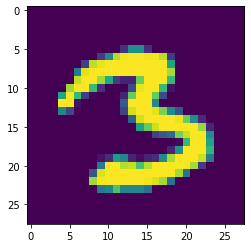

In [45]:
plt.imshow(np.reshape(x_train[0], (28, 28)))

In [123]:
hist = model.fit([anchor_train, positive_train, negative_train],
          y               = y_train,
          validation_data = ([anchor_test,positive_test,negative_test], y_test), 
          batch_size      = 128, 
          epochs          = 20, 
          callbacks       = [live_action]
          ) 


mlflow.log_param("Regularisation", reg)
mlflow.log_param("Activation", activation)
mlflow.log_param("m", m)
mlflow.log_metric("loss", hist.history['loss'][-1])
mlflow.keras.log_model(model, "models")

Train on 35000 samples, validate on 2000 samples
Epoch 1/20
35000/35000 [==============================] - 154s 4ms/step - loss: 0.2677 - val_loss: 0.0782
Epoch 2/20
35000/35000 [==============================] - 146s 4ms/step - loss: 0.0932 - val_loss: 0.0465
Epoch 3/20
35000/35000 [==============================] - 148s 4ms/step - loss: 0.0564 - val_loss: 0.0297
Epoch 4/20
35000/35000 [==============================] - 146s 4ms/step - loss: 0.0404 - val_loss: 0.0265
Epoch 5/20
35000/35000 [==============================] - 146s 4ms/step - loss: 0.0307 - val_loss: 0.0263
Epoch 6/20
35000/35000 [==============================] - 146s 4ms/step - loss: 0.0256 - val_loss: 0.0240
Epoch 7/20
35000/35000 [==============================] - 146s 4ms/step - loss: 0.0213 - val_loss: 0.0254
Epoch 8/20
35000/35000 [==============================] - 162s 5ms/step - loss: 0.0193 - val_loss: 0.0215
Epoch 9/20
35000/35000 [==============================] - 195s 6ms/step - loss: 0.0167 - val_loss: 0.02

C:\Users\Utilisateur\.conda\envs\keelab\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.528195). Check your callbacks.
  % delta_t_median)


35000/35000 [==============================] - 147s 4ms/step - loss: 0.0127 - val_loss: 0.0201
Epoch 14/20
35000/35000 [==============================] - 147s 4ms/step - loss: 0.0109 - val_loss: 0.0226
Epoch 15/20
35000/35000 [==============================] - 148s 4ms/step - loss: 0.0101 - val_loss: 0.0215
Epoch 16/20
35000/35000 [==============================] - 147s 4ms/step - loss: 0.0100 - val_loss: 0.0240
Epoch 17/20
35000/35000 [==============================] - 147s 4ms/step - loss: 0.0093 - val_loss: 0.0250
Epoch 18/20
35000/35000 [==============================] - 148s 4ms/step - loss: 0.0088 - val_loss: 0.0188
Epoch 19/20
35000/35000 [==============================] - 158s 5ms/step - loss: 0.0078 - val_loss: 0.0228
Epoch 20/20
35000/35000 [==============================] - 153s 4ms/step - loss: 0.0075 - val_loss: 0.0244


In [124]:
x = trained_model.predict(x_test.reshape(-1,28,28,1))

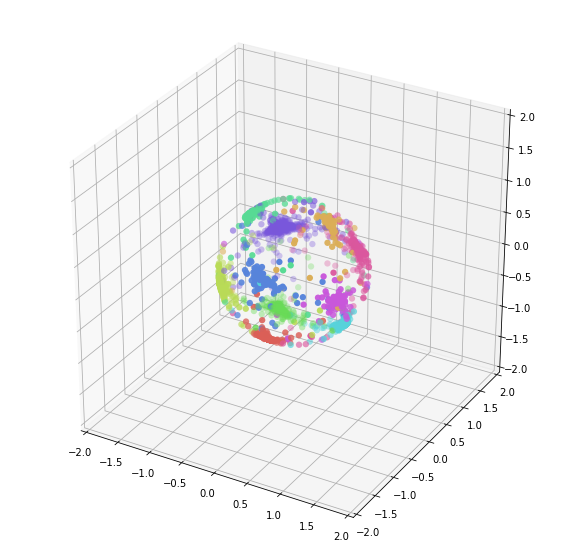

In [125]:
palette = np.array(sns.color_palette("hls", 10))
fig = plt.figure(figsize = (10,10))
ax  = plt.axes(projection="3d")
ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                    c=palette[np.array(y_test_).astype(np.int)]);
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
fig.savefig('')

In [126]:
model.save_weights('./poid')

In [127]:
new_model = Model(inputs = anchor_input, outputs = anchor)

In [128]:
new_model.load_weights('./poid')

In [129]:
x = new_model(anchor_input)
x = kl.Dense(10, activation = 'softmax')(x)

In [130]:
model_classifier = Model(inputs = anchor_input, output = x)

C:\Users\Utilisateur\.conda\envs\keelab\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("an..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [131]:
for l in model_classifier.layers[:-1]:
    l.trainable = False

In [136]:
opt = Adagrad()

In [137]:
model_classifier.compile(loss      = "categorical_crossentropy", 
              optimizer = opt,
              metrics   = ["accuracy"])

In [138]:
hist = model_classifier.fit(x_train,
          y               = y_train2,
          validation_data = (x_test, y_test2), 
          batch_size      = 128, 
          epochs          = 10
          ) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 70s 1ms/step - loss: 1.7227 - acc: 0.7412 - val_loss: 1.4299 - val_acc: 0.9855
Epoch 2/10
60000/60000 [==============================] - 62s 1ms/step - loss: 1.2770 - acc: 0.9856 - val_loss: 1.1333 - val_acc: 0.9868
Epoch 3/10
60000/60000 [==============================] - 79s 1ms/step - loss: 1.0431 - acc: 0.9878 - val_loss: 0.9443 - val_acc: 0.9874
Epoch 4/10
60000/60000 [==============================] - 68s 1ms/step - loss: 0.8847 - acc: 0.9887 - val_loss: 0.8096 - val_acc: 0.9878
Epoch 5/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.7685 - acc: 0.9888 - val_loss: 0.7082 - val_acc: 0.9880
Epoch 6/10
60000/60000 [==============================] - 69s 1ms/step - loss: 0.6787 - acc: 0.9888 - val_loss: 0.6289 - val_acc: 0.9881
Epoch 7/10
60000/60000 [==============================] - 72s 1ms/step - loss: 0.6078 - acc: 0.9886 - val_loss: 0.5653 - val_acc

In [132]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
coordOfText            = (10,20)
fontScale              = 0.5
fontColor              = (0,0,0)
lineType               = 2
frame_name             = os.listdir('./movie/')
number_frame           = max([int(name[:-4]) for name in frame_name if name.endswith('.png')])
image_array            = []


In [133]:
for i in range(1, number_frame):
    image = cv2.imread('./movie/{}.png'.format(i))
    image = cv2.putText(image, 'Batch {}'.format(i*70), coordOfText, font, fontScale, fontColor, lineType)
    image_array.append(image)
    
size = (image_array[0].shape[1], image_array[0].shape[0])



In [134]:
fourcc = cv2.VideoWriter_fourcc(*'MP42')
video = cv2.VideoWriter('./noise.avi', fourcc, float(10), size)
for frame in image_array:
    video.write(frame)

In [135]:
video.release()

In [26]:
model.save_weights("model{}.h5".format(time()))

In [31]:
trained_model = Model(inputs = anchor_input, outputs = anchor)

In [32]:
trained_model.load_weights('model1564665143.8570735.h5')

In [33]:
tsne = TSNE(3)
indices = np.arange(10000)
np.random.shuffle(indices)
indices = indices[:600]
X_train_trm = trained_model.predict(x_train[indices].reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test[indices].reshape(-1,28,28,1))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

KeyboardInterrupt: 